### Active learning experiment

<img src="./Perception_4_ActiveLearning_7_OnlineLearning.png" alt="Drawing" style="width: 800px;"/>

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import Dataset, visualize
from augmentations import get_preprocessing, get_training_augmentation, get_validation_augmentation
import torch
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

### Load data

In [2]:
DATA_DIR = './data/CamVid/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# all data paths
X_train_paths = np.array([os.path.join(x_train_dir, image_name) for image_name in os.listdir(x_train_dir)])
y_train_paths = np.array([os.path.join(y_train_dir, image_name) for image_name in os.listdir(y_train_dir)])

X_valid_paths = np.array([os.path.join(x_valid_dir, image_name) for image_name in os.listdir(x_valid_dir)])
y_valid_paths = np.array([os.path.join(y_valid_dir, image_name) for image_name in os.listdir(y_valid_dir)])

X_test_paths = np.array([os.path.join(x_test_dir, image_name) for image_name in os.listdir(x_test_dir)])
y_test_paths = np.array([os.path.join(y_test_dir, image_name) for image_name in os.listdir(y_test_dir)])

### Create model

In [3]:
from abc import ABC, abstractmethod

class BaseModel(ABC):

    def __init__(self):
        pass

    @abstractmethod
    def train(self):
        pass
    
    @abstractmethod
    def predict(self):
        pass


class Unet(BaseModel):
    
    model_type = 'Unet Resnet18'
    
    def __init__(self):
        super(Unet, self).__init__()
        # model params
        self.encoder = 'resnet18'
        self.encoder_weights = 'imagenet'
        self.classes = ['car', 'road']
        self.n_classes = 1 if len(self.classes) == 1 else (len(self.classes) + 1)
        self.activation = 'sigmoid' if len(self.classes) == 1 else 'softmax2d'
        # training params
        self.learning_rate = 1e-4
        self.device = 'cuda'
        self.epochs = 1
        self.batch_size = 8
        self.model = None
        self.preprocessing_fn = smp.encoders.get_preprocessing_fn(self.encoder, self.encoder_weights)
        
    def create_model(self):
        self.model = smp.Unet(encoder_name=self.encoder,
                              encoder_weights=self.encoder_weights,
                              classes=self.n_classes,
                              activation=self.activation)
        return self.model
    
    def create_epoch_runners(self, verbose=False):
        # Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
        # IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
        loss = smp.utils.losses.DiceLoss()
        metrics = [
            smp.utils.metrics.IoU(threshold=0.5),
        ]
        optimizer = torch.optim.Adam([ 
            dict(params=self.model.parameters(), lr=self.learning_rate),
        ])
        # create epoch runners 
        # it is a simple loop of iterating over dataloader`s samples
        train_epoch = smp.utils.train.TrainEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            optimizer=optimizer,
            device=self.device,
            verbose=verbose,
        )
        valid_epoch = smp.utils.train.ValidEpoch(
            self.model, 
            loss=loss, 
            metrics=metrics, 
            device=self.device,
            verbose=verbose,
        )
        
        return train_epoch, valid_epoch
        
    def create_datasets(self, train_images_paths, train_masks_paths, valid_images_paths, valid_masks_paths):
        train_dataset = Dataset(
            train_images_paths, 
            train_masks_paths, 
            augmentation=get_training_augmentation(), 
            preprocessing=get_preprocessing(self.preprocessing_fn),
            classes=self.classes,
        )
        valid_dataset = Dataset(
            valid_images_paths,
            valid_masks_paths,
            augmentation=get_validation_augmentation(), 
            preprocessing=get_preprocessing(self.preprocessing_fn),
            classes=self.classes,
        )
        return train_dataset, valid_dataset
    
    def train(self, train_images_paths, train_masks_paths, valid_images_paths, valid_masks_paths, verbose=False):
        if self.model is None: self.create_model()
        train_epoch, valid_epoch = self.create_epoch_runners(verbose=verbose)
        train_dataset, valid_dataset = self.create_datasets(train_images_paths,
                                                            train_masks_paths,
                                                            valid_images_paths,
                                                            valid_masks_paths)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=12)
        valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)
        # train loop
        max_score = 0
        for i in range(0, self.epochs):
            if verbose: print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader)
            valid_logs = valid_epoch.run(valid_loader)
            # do something (save model, change lr, etc.)
            if max_score < valid_logs['iou_score']:
                max_score = valid_logs['iou_score']
                torch.save(self.model, './unet_best_model.pth')
                if verbose: print('Model saved!')
        # update model with the best saved
        self.model = torch.load('./unet_best_model.pth')
        
    def predict(self, image_paths):
        images = []
        for image_path in image_paths:
            # input preprocessing
            image_raw = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
            image = np.copy(image_raw)
            image = cv2.resize(image, (320, 320))
            preprocessing = get_preprocessing(self.preprocessing_fn)
            image = preprocessing(image=image)['image']
            images.append(image)
        # convert to torch tensor and do inference
        x_tensor = torch.tensor(images).to(self.device)
        predictions = self.model.predict(x_tensor)
        return predictions

### Active Learning experiment

- X_train, y_train: is used partially to train a model
- X_valid, y_valid: is used fully for validation
- X_test, y_test: is used as an unlabelled set to detect anomalies and add labels to train set

Firstly we define Anomaly detection functions here

In [4]:
def entropy(mask_np):
    # mask_np.shape = (3, N, M)
    e = np.mean( (-mask_np * np.log2(mask_np)).sum(axis=0) )
    return e

def entropy_selection(X_test_paths, n_samples, model):
    # do inference and compute entropy for each image
    entropies = []
    print('Inference on unlabelled data...')
    for img_path in tqdm(X_test_paths):
        pr_mask = model.predict([img_path])
        mask_np = pr_mask.squeeze().cpu().numpy()
        entropies.append(entropy(mask_np))
    # Model is mostly uncertain in images with High entropy
    #print('Choosing uncertain images to label...')
    selected_images_indexes = (np.argsort(entropies))[::-1][:n_samples]
    print(f'Min entropy: {np.min(entropies):.2f}, \
            Mean Entropy: {np.mean(entropies):.2f}, \
            Max entropy: {np.max(entropies):.2f}')
    return selected_images_indexes

def random_samples_selection(X, n_samples, model=None):
    selected_images_indexes = np.random.choice(len(X), n_samples, replace=False)
    return selected_images_indexes

Main AL experiment

------------------------------------

Number of samples to label: 10

------------------------------------

Samples selection function:
<function random_samples_selection at 0x7ff95e93e840>
------------------------------------

 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 64.21it/s, dice_loss - 0.697, iou_score - 0.01302]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 64.48it/s, dice_loss - 0.6533, iou_score - 0.1134]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 62.56it/s, dice_loss - 0.6012, iou_score - 0.2212]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 63.60it/s, dice_loss - 0.5594, iou_score - 0.255]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 63.13it/s, dice_loss - 0.5262, iou_score - 0.2964]
Model saved!
Labelled set before:  20
Labelled set after:  30
Visualizing most uncertain results so far:


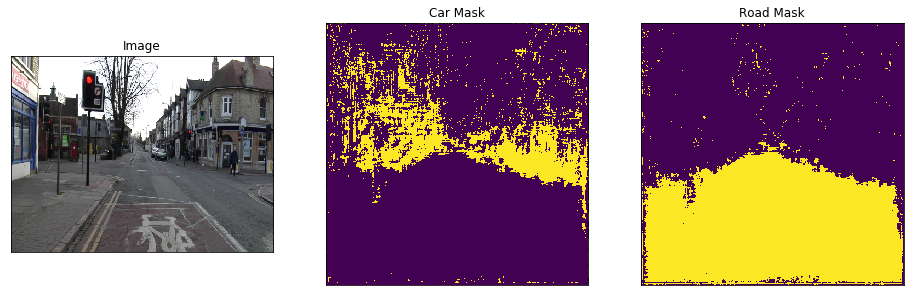

Unlabelled set before:  233
Unlabelled set after:  213
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 62.36it/s, dice_loss - 0.487, iou_score - 0.3779]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 61.74it/s, dice_loss - 0.4643, iou_score - 0.4254]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 61.96it/s, dice_loss - 0.4255, iou_score - 0.5218]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 61.99it/s, dice_loss - 0.4004, iou_score - 0.5974]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 61.53it/s, dice_loss - 0.3518, iou_score - 0.7285]
Model saved!
Labelled set before:  30
Labelled set after:  40
Visualizing most uncertain results so far:


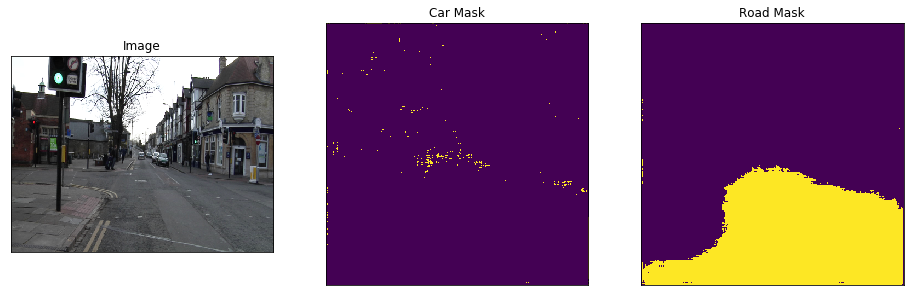

Unlabelled set before:  213
Unlabelled set after:  194
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
train:   0%|          | 0/5 [00:00<?, ?it/s]

/home/ruslan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:59: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


valid: 100%|██████████| 101/101 [00:01<00:00, 64.37it/s, dice_loss - 0.3067, iou_score - 0.8301]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 63.65it/s, dice_loss - 0.3094, iou_score - 0.8112]

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 65.44it/s, dice_loss - 0.296, iou_score - 0.8185]

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 65.36it/s, dice_loss - 0.2526, iou_score - 0.8599]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 64.29it/s, dice_loss - 0.2393, iou_score - 0.8579]
Labelled set before:  40
Labelled set after:  50
Visualizing most uncertain results so far:


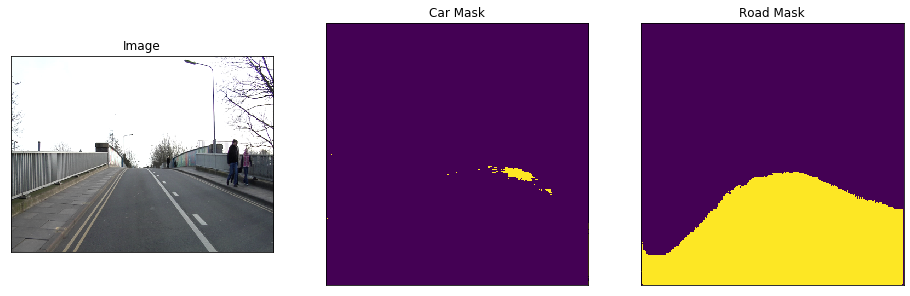

Unlabelled set before:  194
Unlabelled set after:  174
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 64.84it/s, dice_loss - 0.246, iou_score - 0.8626]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 65.36it/s, dice_loss - 0.239, iou_score - 0.8631]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 66.66it/s, dice_loss - 0.2217, iou_score - 0.8702]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 64.70it/s, dice_loss - 0.2084, iou_score - 0.8785]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 59.30it/s, dice_loss - 0.2021, iou_score - 0.8804]
Model saved!
Labelled set before:  50
Labelled set after:  60
Visualizing most uncertain results so far:


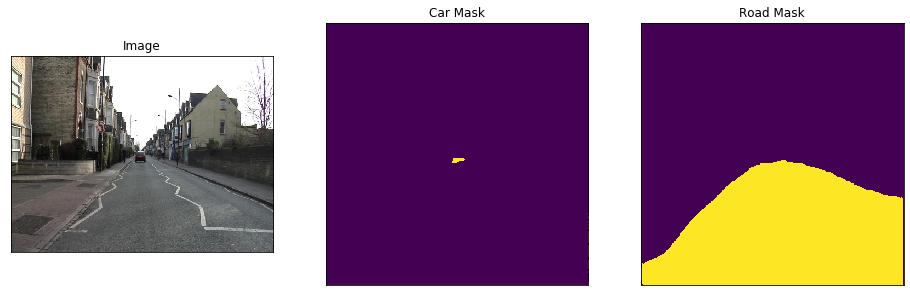

Unlabelled set before:  174
Unlabelled set after:  155
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 66.52it/s, dice_loss - 0.1969, iou_score - 0.8517]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 66.30it/s, dice_loss - 0.1745, iou_score - 0.8933]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 64.04it/s, dice_loss - 0.1548, iou_score - 0.9012]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 63.90it/s, dice_loss - 0.142, iou_score - 0.8967]

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 64.01it/s, dice_loss - 0.1523, iou_score - 0.8874]
Labelled set before:  60
Labelled set after:  70
Visualizing most uncertain results so far:


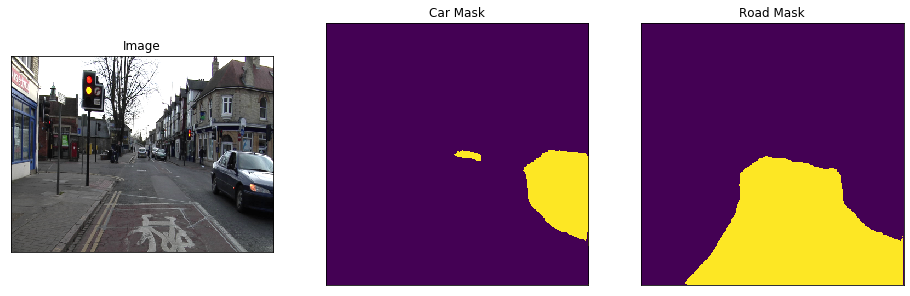

Unlabelled set before:  155
Unlabelled set after:  138
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 57.30it/s, dice_loss - 0.1551, iou_score - 0.898]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 63.06it/s, dice_loss - 0.1253, iou_score - 0.9221]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 63.10it/s, dice_loss - 0.1251, iou_score - 0.9103]

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 63.66it/s, dice_loss - 0.1075, iou_score - 0.9271]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 63.06it/s, dice_loss - 0.1107, iou_score - 0.911]
Labelled set before:  70
Labelled set after:  80
Visualizing most uncertain results so far:


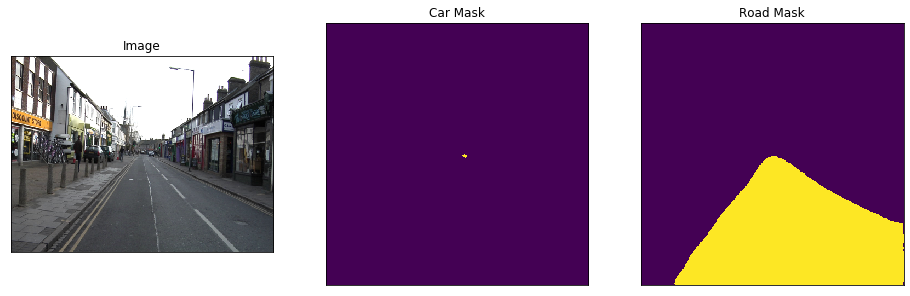

Unlabelled set before:  138
Unlabelled set after:  118
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 58.05it/s, dice_loss - 0.09677, iou_score - 0.9327]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 63.35it/s, dice_loss - 0.1005, iou_score - 0.9099]

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 64.09it/s, dice_loss - 0.1036, iou_score - 0.9044]

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 61.03it/s, dice_loss - 0.08957, iou_score - 0.9142]

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 59.60it/s, dice_loss - 0.09242, iou_score - 0.9028]
Labelled set before:  80
Labelled set after:  90
Visualizing most uncertain results so far:


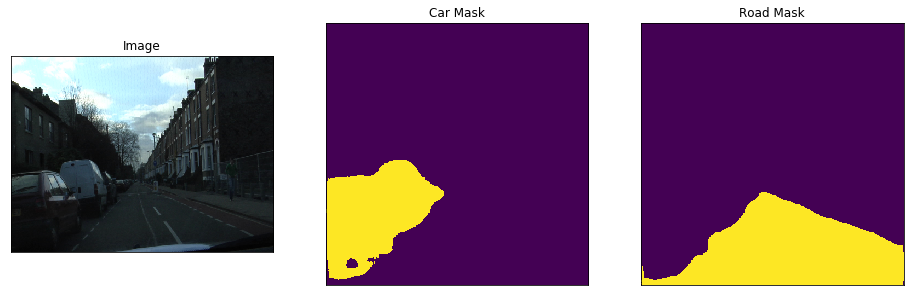

Unlabelled set before:  118
Unlabelled set after:  101
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 57.03it/s, dice_loss - 0.1009, iou_score - 0.915]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 60.37it/s, dice_loss - 0.09659, iou_score - 0.9171]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 62.35it/s, dice_loss - 0.07974, iou_score - 0.9292]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 58.20it/s, dice_loss - 0.07326, iou_score - 0.9311]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 59.99it/s, dice_loss - 0.0768, iou_score - 0.92]  
Labelled set before:  90
Labelled set after:  100
Visualizing most uncertain results so far:


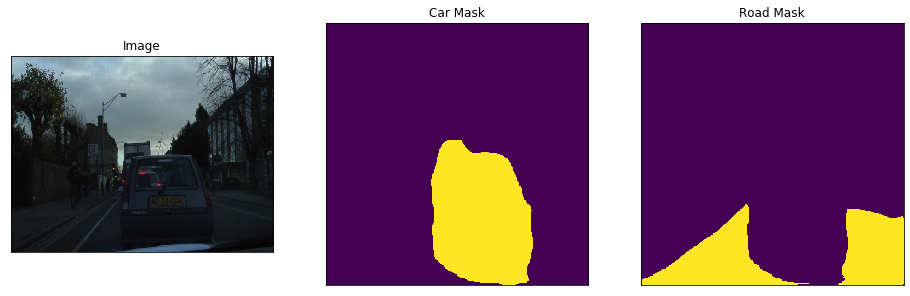

Unlabelled set before:  101
Unlabelled set after:  83
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 63.03it/s, dice_loss - 0.07823, iou_score - 0.9119]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 64.41it/s, dice_loss - 0.06857, iou_score - 0.9222]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 64.56it/s, dice_loss - 0.05471, iou_score - 0.9399]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 59.82it/s, dice_loss - 0.06099, iou_score - 0.9227]

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 63.73it/s, dice_loss - 0.0528, iou_score - 0.9366]
Labelled set before:  100
Labelled set after:  110
Visualizing most uncertain results so far:


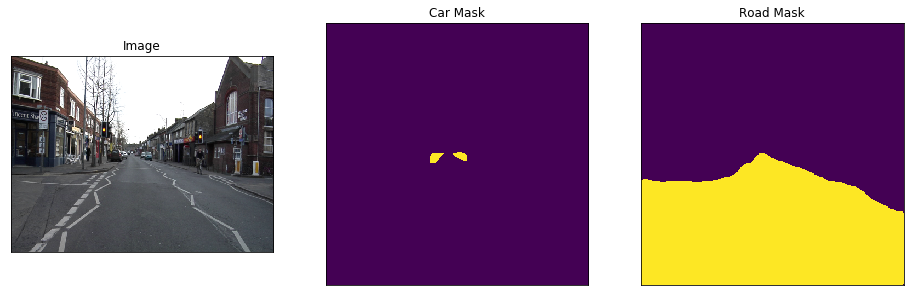

Unlabelled set before:  83
Unlabelled set after:  63
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 63.23it/s, dice_loss - 0.05934, iou_score - 0.9305]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 65.05it/s, dice_loss - 0.04668, iou_score - 0.9455]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 60.73it/s, dice_loss - 0.04822, iou_score - 0.9376]

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 63.91it/s, dice_loss - 0.04283, iou_score - 0.9438]

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 64.07it/s, dice_loss - 0.04128, iou_score - 0.9443]
Labelled set before:  110
Labelled set after:  120
Visualizing most uncertain results so far:


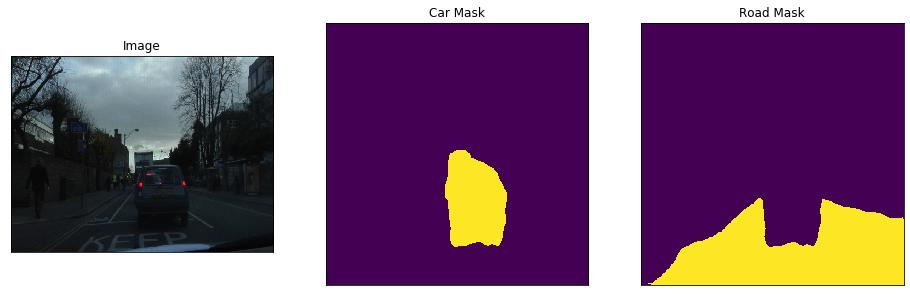

Unlabelled set before:  63
Unlabelled set after:  43
----------------------------------------


Samples selection function:
<function entropy_selection at 0x7ffa4029cae8>
------------------------------------

 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 61.76it/s, dice_loss - 0.7719, iou_score - 0.01836]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 63.27it/s, dice_loss - 0.7397, iou_score - 0.01742]

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 62.90it/s, dice_loss - 0.6929, iou_score - 0.03678]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 63.91it/s, dice_loss - 0.6412, iou_score - 0.1641]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 61.53it/s, dice_loss - 0.5999, iou_score - 0.2912]
Model saved!


  0%|          | 0/233 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 233/233 [00:11<00:00, 20.10it/s]


Min entropy: 1.25,             Mean Entropy: 1.38,             Max entropy: 1.46
Labelled set before:  20
Labelled set after:  30
Visualizing most uncertain results so far:


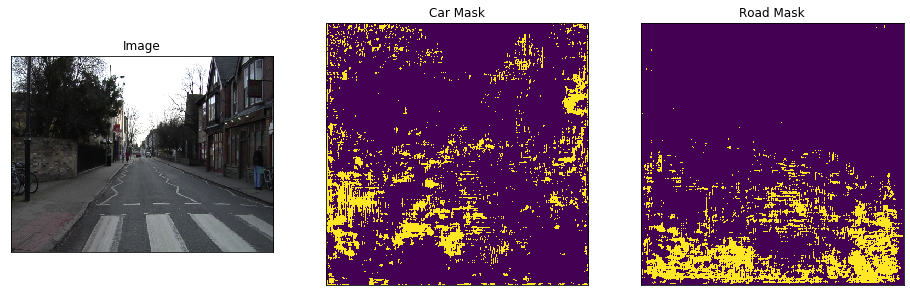

Unlabelled set before:  233
Unlabelled set after:  214
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 65.39it/s, dice_loss - 0.5148, iou_score - 0.4828]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 62.74it/s, dice_loss - 0.4888, iou_score - 0.5159]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 59.57it/s, dice_loss - 0.4639, iou_score - 0.5547]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 58.63it/s, dice_loss - 0.4378, iou_score - 0.5984]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 60.15it/s, dice_loss - 0.4034, iou_score - 0.6666]
Model saved!


  0%|          | 0/214 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 214/214 [00:10<00:00, 21.12it/s]


Min entropy: 1.06,             Mean Entropy: 1.16,             Max entropy: 1.28
Labelled set before:  30
Labelled set after:  40
Visualizing most uncertain results so far:


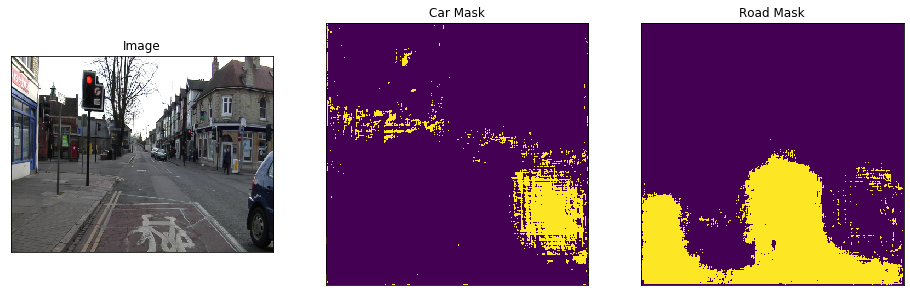

Unlabelled set before:  214
Unlabelled set after:  194
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 63.56it/s, dice_loss - 0.3864, iou_score - 0.7113]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 64.39it/s, dice_loss - 0.3542, iou_score - 0.7871]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 59.11it/s, dice_loss - 0.3334, iou_score - 0.8131]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 59.50it/s, dice_loss - 0.3177, iou_score - 0.8228]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 58.19it/s, dice_loss - 0.2962, iou_score - 0.8535]
Model saved!


  0%|          | 0/194 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 194/194 [00:09<00:00, 20.96it/s]


Min entropy: 0.91,             Mean Entropy: 1.02,             Max entropy: 1.09
Labelled set before:  40
Labelled set after:  50
Visualizing most uncertain results so far:


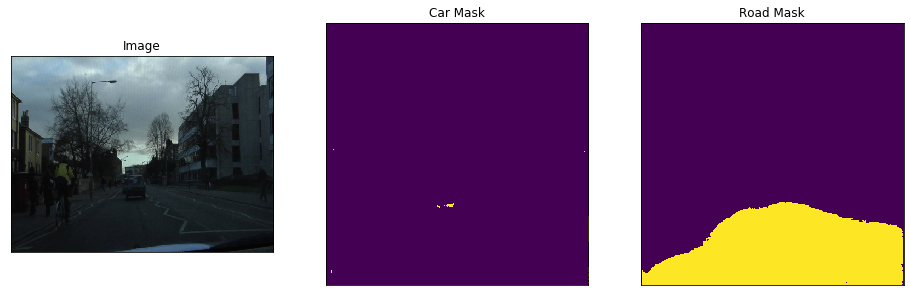

Unlabelled set before:  194
Unlabelled set after:  175
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 62.68it/s, dice_loss - 0.274, iou_score - 0.8901]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 60.01it/s, dice_loss - 0.2691, iou_score - 0.8949]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 59.68it/s, dice_loss - 0.2657, iou_score - 0.8855]

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 57.50it/s, dice_loss - 0.2425, iou_score - 0.9028]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 62.75it/s, dice_loss - 0.2209, iou_score - 0.9315]
Model saved!


  0%|          | 0/175 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 175/175 [00:08<00:00, 20.87it/s]


Min entropy: 0.71,             Mean Entropy: 0.87,             Max entropy: 0.95
Labelled set before:  50
Labelled set after:  60
Visualizing most uncertain results so far:


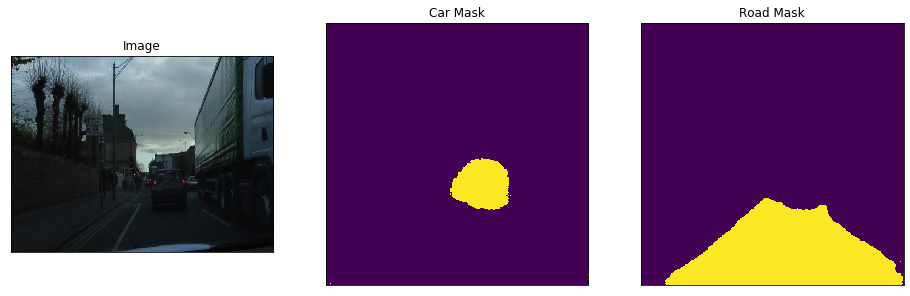

Unlabelled set before:  175
Unlabelled set after:  156
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 64.09it/s, dice_loss - 0.2201, iou_score - 0.9147]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 62.83it/s, dice_loss - 0.1963, iou_score - 0.9282]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 62.21it/s, dice_loss - 0.1906, iou_score - 0.9234]

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 63.23it/s, dice_loss - 0.1834, iou_score - 0.9179]

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 61.77it/s, dice_loss - 0.1749, iou_score - 0.9267]
Inference on unlabelled data...


100%|██████████| 156/156 [00:08<00:00, 18.72it/s]


Min entropy: 0.63,             Mean Entropy: 0.80,             Max entropy: 0.88
Labelled set before:  60
Labelled set after:  70
Visualizing most uncertain results so far:


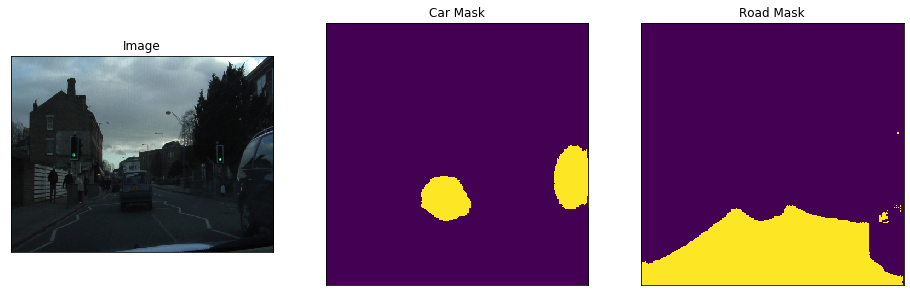

Unlabelled set before:  156
Unlabelled set after:  136
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 62.37it/s, dice_loss - 0.1825, iou_score - 0.9304]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 64.73it/s, dice_loss - 0.1818, iou_score - 0.9239]

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 63.81it/s, dice_loss - 0.1654, iou_score - 0.9449]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 63.29it/s, dice_loss - 0.1467, iou_score - 0.9444]

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 60.15it/s, dice_loss - 0.137, iou_score - 0.9364]


  0%|          | 0/136 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 136/136 [00:07<00:00, 18.99it/s]


Min entropy: 0.60,             Mean Entropy: 0.70,             Max entropy: 0.75
Labelled set before:  70
Labelled set after:  80
Visualizing most uncertain results so far:


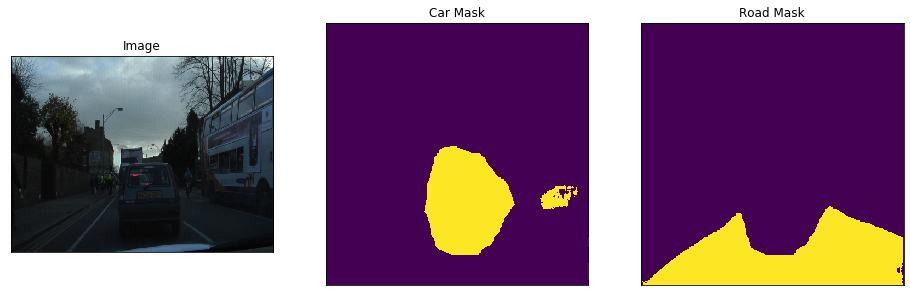

Unlabelled set before:  136
Unlabelled set after:  116
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 61.87it/s, dice_loss - 0.146, iou_score - 0.9429]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 61.96it/s, dice_loss - 0.1358, iou_score - 0.9449]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 63.14it/s, dice_loss - 0.1165, iou_score - 0.9559]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 63.20it/s, dice_loss - 0.107, iou_score - 0.9502]

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 58.47it/s, dice_loss - 0.09713, iou_score - 0.9528]


  0%|          | 0/116 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 116/116 [00:05<00:00, 19.51it/s]


Min entropy: 0.48,             Mean Entropy: 0.54,             Max entropy: 0.61
Labelled set before:  80
Labelled set after:  90
Visualizing most uncertain results so far:


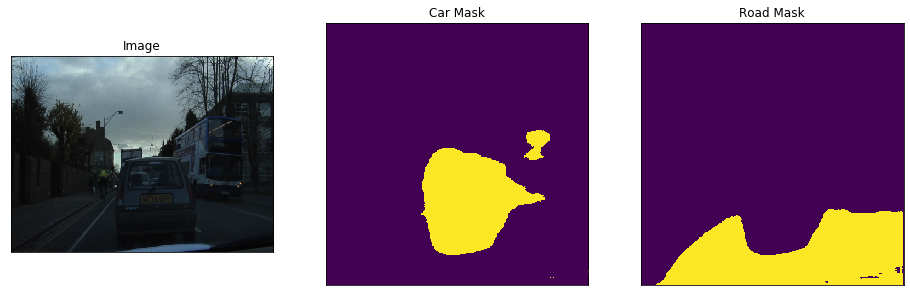

Unlabelled set before:  116
Unlabelled set after:  96
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 62.13it/s, dice_loss - 0.1026, iou_score - 0.9499]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 61.46it/s, dice_loss - 0.09172, iou_score - 0.944]

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 61.83it/s, dice_loss - 0.085, iou_score - 0.9497] 

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 62.22it/s, dice_loss - 0.07689, iou_score - 0.9476]

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 61.63it/s, dice_loss - 0.06915, iou_score - 0.9577]
Model saved!


  0%|          | 0/96 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 96/96 [00:04<00:00, 21.31it/s]


Min entropy: 0.28,             Mean Entropy: 0.32,             Max entropy: 0.36
Labelled set before:  90
Labelled set after:  100
Visualizing most uncertain results so far:


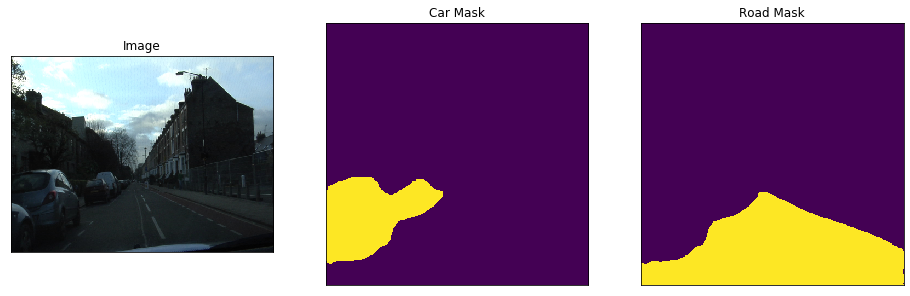

Unlabelled set before:  96
Unlabelled set after:  79
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 64.02it/s, dice_loss - 0.06039, iou_score - 0.9573]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 63.47it/s, dice_loss - 0.05824, iou_score - 0.9507]

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 63.43it/s, dice_loss - 0.05368, iou_score - 0.9508]

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 63.14it/s, dice_loss - 0.04585, iou_score - 0.9586]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 62.59it/s, dice_loss - 0.0449, iou_score - 0.9578]


  0%|          | 0/79 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 79/79 [00:04<00:00, 16.65it/s]


Min entropy: 0.18,             Mean Entropy: 0.20,             Max entropy: 0.23
Labelled set before:  100
Labelled set after:  110
Visualizing most uncertain results so far:


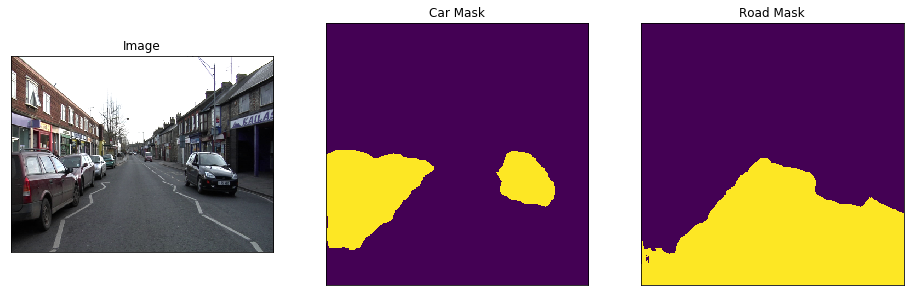

Unlabelled set before:  79
Unlabelled set after:  61
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 62.09it/s, dice_loss - 0.04693, iou_score - 0.951]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 63.45it/s, dice_loss - 0.03933, iou_score - 0.9575]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 57.53it/s, dice_loss - 0.03592, iou_score - 0.9601]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 59.96it/s, dice_loss - 0.03784, iou_score - 0.953]

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 57.67it/s, dice_loss - 0.04335, iou_score - 0.9403]


  0%|          | 0/61 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 61/61 [00:03<00:00, 17.84it/s]


Min entropy: 0.11,             Mean Entropy: 0.13,             Max entropy: 0.15
Labelled set before:  110
Labelled set after:  120
Visualizing most uncertain results so far:


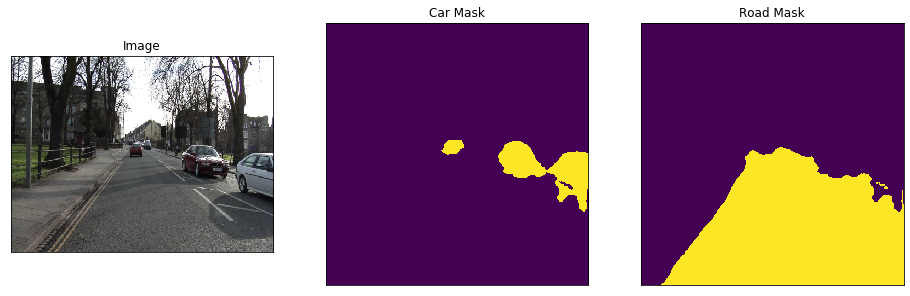

Unlabelled set before:  61
Unlabelled set after:  43
----------------------------------------

------------------------------------

Number of samples to label: 20

------------------------------------

Samples selection function:
<function random_samples_selection at 0x7ff95e93e840>
------------------------------------

 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 61.83it/s, dice_loss - 0.7652, iou_score - 0.01057]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 62.49it/s, dice_loss - 0.8008, iou_score - 0.01004]

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 59.34it/s, dice_loss - 0.7941, iou_score - 0.013]  
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 64.29it/s, dice_loss - 0.742, iou_score - 0.08722]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 63.46it/s, dice_loss - 0.6875, iou_score - 0.1518]
Model saved!
Labelled set before:  20
Labelled set after:  40
Visu

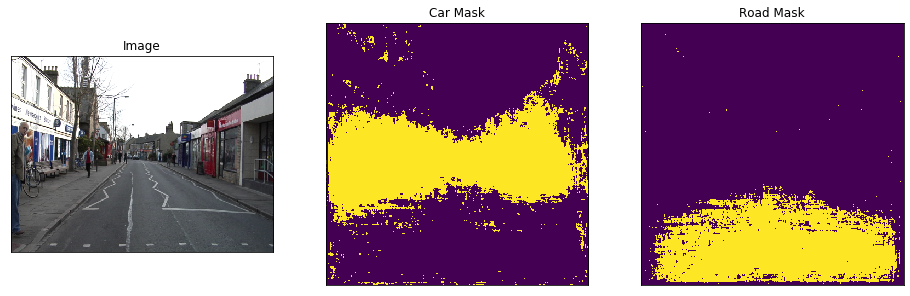

Unlabelled set before:  233
Unlabelled set after:  194
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 56.71it/s, dice_loss - 0.5986, iou_score - 0.2149]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 61.47it/s, dice_loss - 0.5481, iou_score - 0.3312]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 63.30it/s, dice_loss - 0.5054, iou_score - 0.5026]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 66.78it/s, dice_loss - 0.4424, iou_score - 0.7211]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 65.84it/s, dice_loss - 0.3922, iou_score - 0.8269]
Model saved!
Labelled set before:  40
Labelled set after:  60
Visualizing most uncertain results so far:


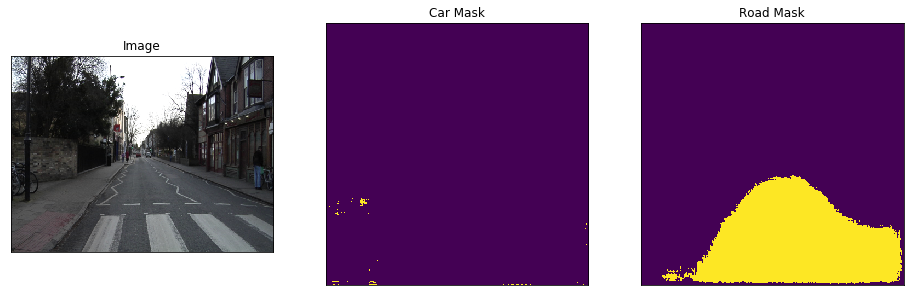

Unlabelled set before:  194
Unlabelled set after:  156
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 66.85it/s, dice_loss - 0.367, iou_score - 0.866] 
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 65.13it/s, dice_loss - 0.3386, iou_score - 0.8605]

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 63.57it/s, dice_loss - 0.3246, iou_score - 0.8609]

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 64.91it/s, dice_loss - 0.3215, iou_score - 0.8595]

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 63.56it/s, dice_loss - 0.3052, iou_score - 0.8588]
Labelled set before:  60
Labelled set after:  80
Visualizing most uncertain results so far:


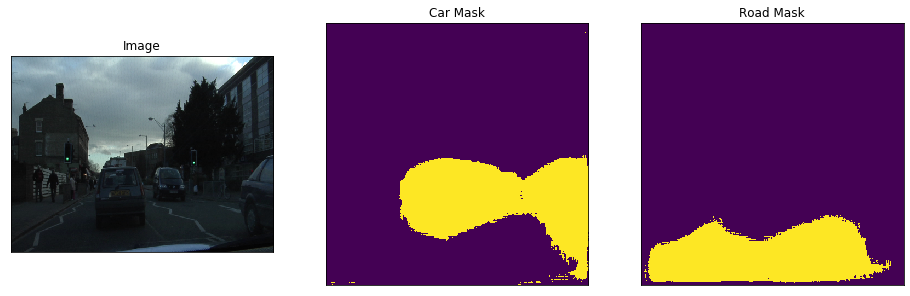

Unlabelled set before:  156
Unlabelled set after:  119
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 65.78it/s, dice_loss - 0.3378, iou_score - 0.8654]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 67.02it/s, dice_loss - 0.3061, iou_score - 0.892]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 66.95it/s, dice_loss - 0.2821, iou_score - 0.895]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 67.02it/s, dice_loss - 0.2924, iou_score - 0.8616]

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 67.26it/s, dice_loss - 0.2768, iou_score - 0.8846]
Labelled set before:  80
Labelled set after:  100
Visualizing most uncertain results so far:


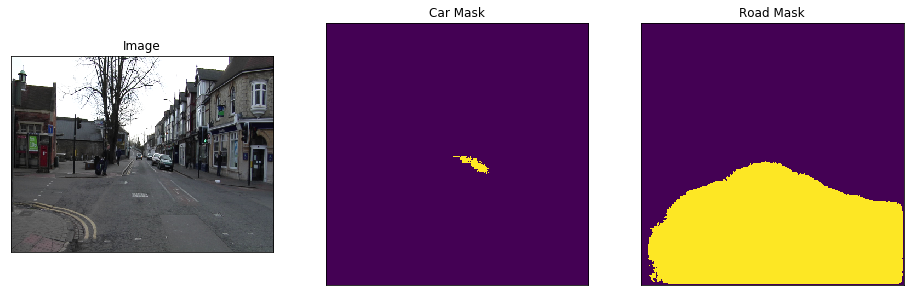

Unlabelled set before:  119
Unlabelled set after:  82
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 66.84it/s, dice_loss - 0.2905, iou_score - 0.8529]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 61.21it/s, dice_loss - 0.2708, iou_score - 0.854]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 66.80it/s, dice_loss - 0.2485, iou_score - 0.8829]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 65.90it/s, dice_loss - 0.2114, iou_score - 0.9167]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 63.10it/s, dice_loss - 0.196, iou_score - 0.9037]
Labelled set before:  100
Labelled set after:  120
Visualizing most uncertain results so far:


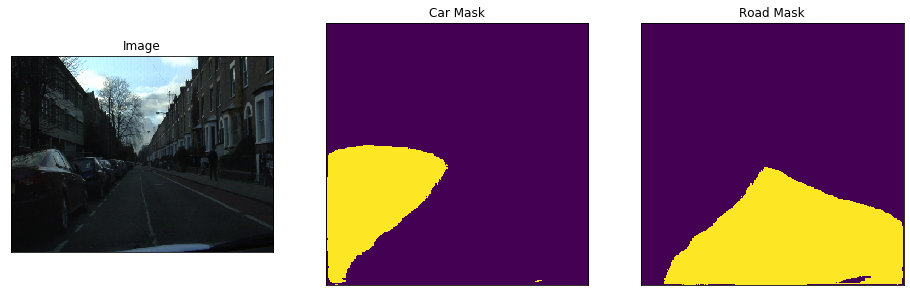

Unlabelled set before:  82
Unlabelled set after:  45
----------------------------------------


Samples selection function:
<function entropy_selection at 0x7ffa4029cae8>
------------------------------------

 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 64.24it/s, dice_loss - 0.6679, iou_score - 0.01393]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 67.06it/s, dice_loss - 0.6424, iou_score - 0.07219]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 66.91it/s, dice_loss - 0.6142, iou_score - 0.1753]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 67.22it/s, dice_loss - 0.5788, iou_score - 0.3348]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 66.93it/s, dice_loss - 0.5351, iou_score - 0.4456]
Model saved!


  0%|          | 0/233 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 233/233 [00:11<00:00, 20.41it/s]


Min entropy: 1.18,             Mean Entropy: 1.30,             Max entropy: 1.40
Labelled set before:  20
Labelled set after:  40
Visualizing most uncertain results so far:


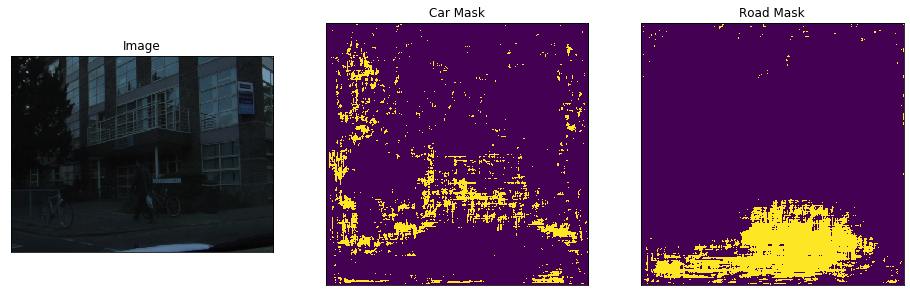

Unlabelled set before:  233
Unlabelled set after:  193
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 61.49it/s, dice_loss - 0.5049, iou_score - 0.4611]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 66.91it/s, dice_loss - 0.4664, iou_score - 0.5234]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 67.12it/s, dice_loss - 0.3926, iou_score - 0.6694]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 67.20it/s, dice_loss - 0.3411, iou_score - 0.7506]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 65.99it/s, dice_loss - 0.3104, iou_score - 0.771]
Model saved!


  0%|          | 0/193 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 193/193 [00:08<00:00, 23.86it/s]


Min entropy: 0.87,             Mean Entropy: 0.95,             Max entropy: 1.04
Labelled set before:  40
Labelled set after:  60
Visualizing most uncertain results so far:


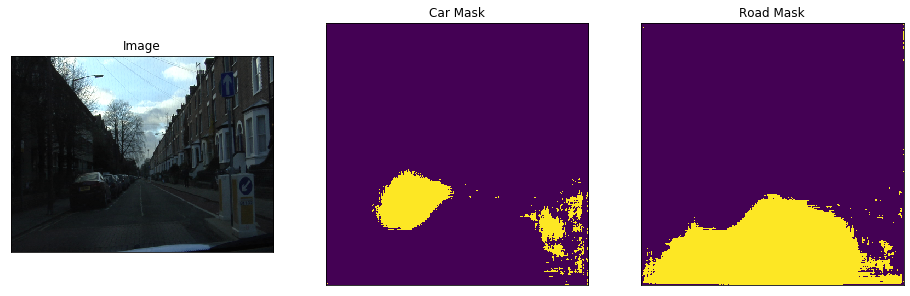

Unlabelled set before:  193
Unlabelled set after:  156
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 67.25it/s, dice_loss - 0.2762, iou_score - 0.7906]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 66.82it/s, dice_loss - 0.2469, iou_score - 0.8371]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 60.99it/s, dice_loss - 0.2164, iou_score - 0.833] 

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 66.59it/s, dice_loss - 0.1975, iou_score - 0.8707]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 66.65it/s, dice_loss - 0.1808, iou_score - 0.8902]
Model saved!


  0%|          | 0/156 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 156/156 [00:06<00:00, 23.95it/s]


Min entropy: 0.61,             Mean Entropy: 0.68,             Max entropy: 0.77
Labelled set before:  60
Labelled set after:  80
Visualizing most uncertain results so far:


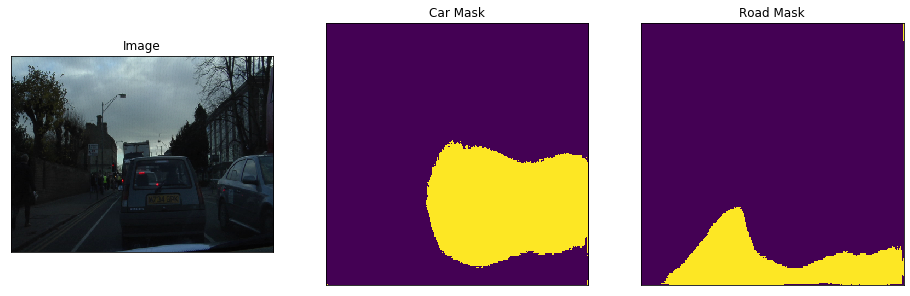

Unlabelled set before:  156
Unlabelled set after:  121
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 67.31it/s, dice_loss - 0.1711, iou_score - 0.8767]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 67.14it/s, dice_loss - 0.1535, iou_score - 0.8802]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 67.36it/s, dice_loss - 0.1441, iou_score - 0.8804]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 61.38it/s, dice_loss - 0.1319, iou_score - 0.9015]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 67.38it/s, dice_loss - 0.1138, iou_score - 0.9173]
Model saved!


  0%|          | 0/121 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 121/121 [00:05<00:00, 22.78it/s]


Min entropy: 0.41,             Mean Entropy: 0.45,             Max entropy: 0.47
Labelled set before:  80
Labelled set after:  100
Visualizing most uncertain results so far:


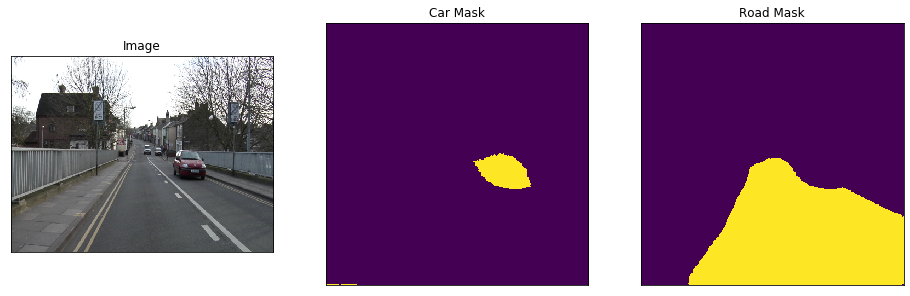

Unlabelled set before:  121
Unlabelled set after:  84
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 67.74it/s, dice_loss - 0.09057, iou_score - 0.9331]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 66.77it/s, dice_loss - 0.07997, iou_score - 0.9419]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 67.18it/s, dice_loss - 0.08882, iou_score - 0.9205]

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 60.70it/s, dice_loss - 0.07926, iou_score - 0.9186]

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 66.99it/s, dice_loss - 0.07445, iou_score - 0.9247]


  0%|          | 0/84 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 84/84 [00:03<00:00, 22.97it/s]


Min entropy: 0.31,             Mean Entropy: 0.34,             Max entropy: 0.36
Labelled set before:  100
Labelled set after:  120
Visualizing most uncertain results so far:


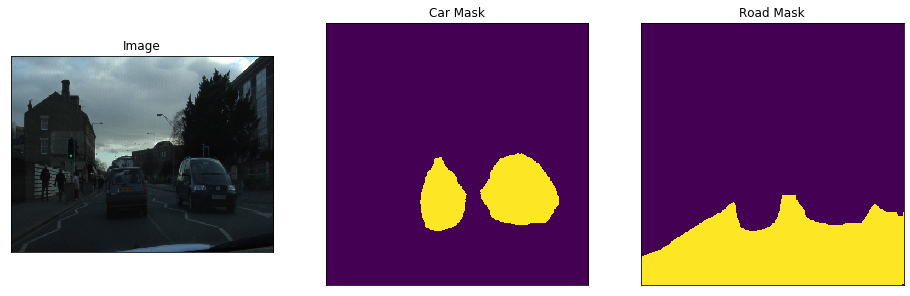

Unlabelled set before:  84
Unlabelled set after:  49
----------------------------------------

------------------------------------

Number of samples to label: 40

------------------------------------

Samples selection function:
<function random_samples_selection at 0x7ff95e93e840>
------------------------------------

 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 67.44it/s, dice_loss - 0.6797, iou_score - 0.0297]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 66.95it/s, dice_loss - 0.6413, iou_score - 0.08353]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 66.82it/s, dice_loss - 0.5931, iou_score - 0.2403]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 60.47it/s, dice_loss - 0.5347, iou_score - 0.384] 
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 64.79it/s, dice_loss - 0.4645, iou_score - 0.4943]
Model saved!
Labelled set before:  20
Labelled set afte

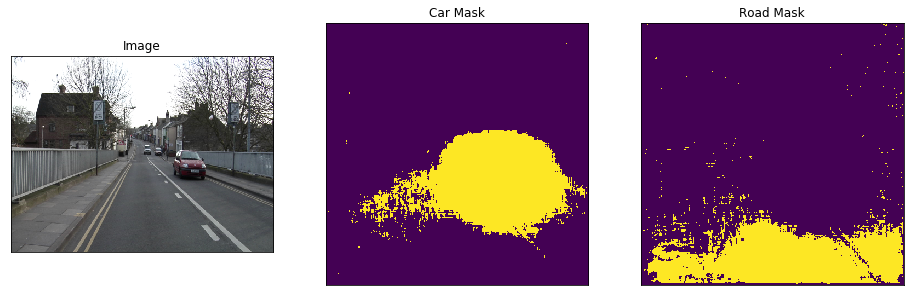

Unlabelled set before:  233
Unlabelled set after:  157
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 66.98it/s, dice_loss - 0.2929, iou_score - 0.7676]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 66.54it/s, dice_loss - 0.268, iou_score - 0.7873]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 67.37it/s, dice_loss - 0.2411, iou_score - 0.8204]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 66.92it/s, dice_loss - 0.2363, iou_score - 0.8246]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 66.68it/s, dice_loss - 0.2075, iou_score - 0.8563]
Model saved!
Labelled set before:  60
Labelled set after:  100
Visualizing most uncertain results so far:


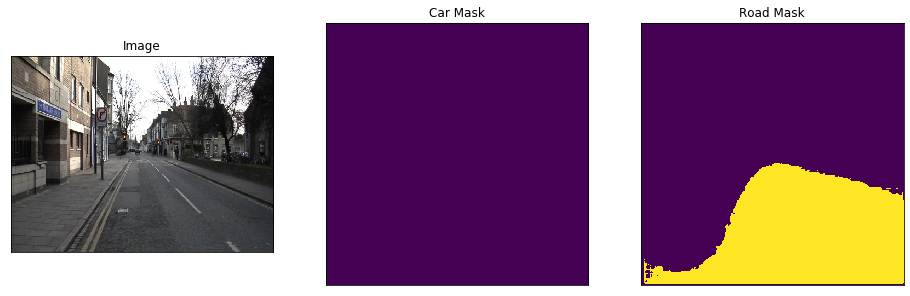

Unlabelled set before:  157
Unlabelled set after:  85
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 65.48it/s, dice_loss - 0.1733, iou_score - 0.8872]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 64.45it/s, dice_loss - 0.1488, iou_score - 0.9047]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 65.85it/s, dice_loss - 0.1368, iou_score - 0.9042]

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 67.14it/s, dice_loss - 0.1251, iou_score - 0.9142]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 66.83it/s, dice_loss - 0.1213, iou_score - 0.8949]
Labelled set before:  100
Labelled set after:  140
Visualizing most uncertain results so far:


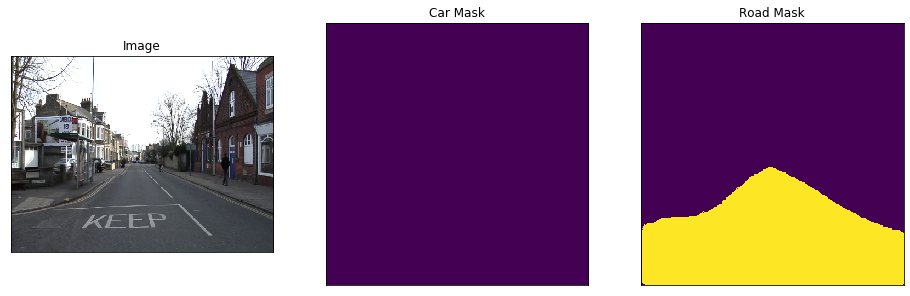

Unlabelled set before:  85
Unlabelled set after:  21
----------------------------------------


Samples selection function:
<function entropy_selection at 0x7ffa4029cae8>
------------------------------------

 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 61.16it/s, dice_loss - 0.6226, iou_score - 0.137]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 65.84it/s, dice_loss - 0.5964, iou_score - 0.184]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 66.86it/s, dice_loss - 0.5739, iou_score - 0.2385]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 66.22it/s, dice_loss - 0.541, iou_score - 0.3531]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 67.28it/s, dice_loss - 0.4808, iou_score - 0.4821]
Model saved!


  0%|          | 0/233 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 233/233 [00:11<00:00, 21.01it/s]


Min entropy: 1.02,             Mean Entropy: 1.24,             Max entropy: 1.47
Labelled set before:  20
Labelled set after:  60
Visualizing most uncertain results so far:


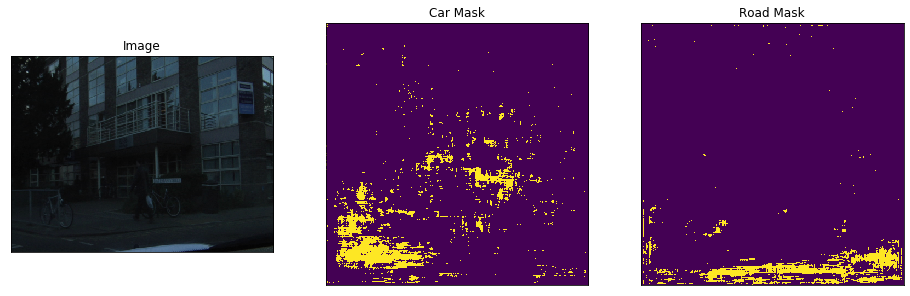

Unlabelled set before:  233
Unlabelled set after:  163
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 66.78it/s, dice_loss - 0.2896, iou_score - 0.7405]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 66.20it/s, dice_loss - 0.2169, iou_score - 0.8252]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 66.90it/s, dice_loss - 0.2075, iou_score - 0.8293]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 67.38it/s, dice_loss - 0.1689, iou_score - 0.8717]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 65.77it/s, dice_loss - 0.1259, iou_score - 0.91] 
Model saved!


  0%|          | 0/163 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 163/163 [00:08<00:00, 20.12it/s]


Min entropy: 0.48,             Mean Entropy: 0.52,             Max entropy: 0.62
Labelled set before:  60
Labelled set after:  100
Visualizing most uncertain results so far:


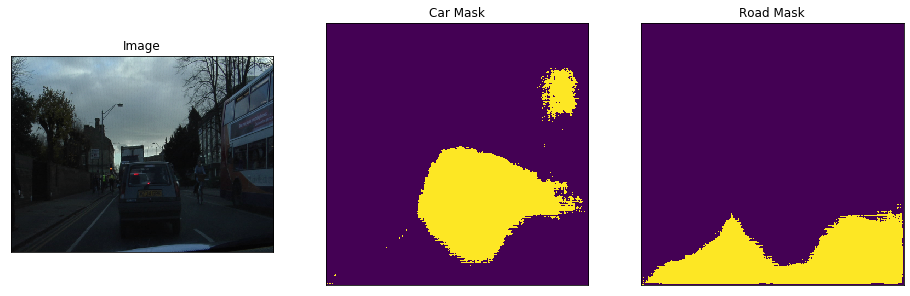

Unlabelled set before:  163
Unlabelled set after:  95
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 63.59it/s, dice_loss - 0.1064, iou_score - 0.9001]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 66.34it/s, dice_loss - 0.0922, iou_score - 0.9187]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 67.06it/s, dice_loss - 0.07953, iou_score - 0.932]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 61.63it/s, dice_loss - 0.06791, iou_score - 0.9408]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 67.37it/s, dice_loss - 0.06223, iou_score - 0.9389]


  0%|          | 0/95 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 95/95 [00:04<00:00, 21.93it/s]


Min entropy: 0.27,             Mean Entropy: 0.29,             Max entropy: 0.36
Labelled set before:  100
Labelled set after:  140
Visualizing most uncertain results so far:


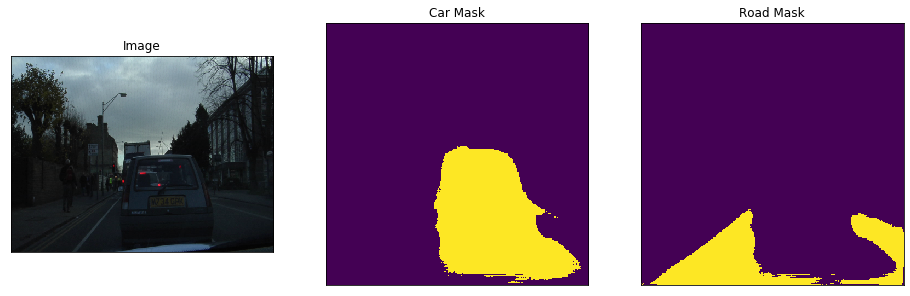

Unlabelled set before:  95
Unlabelled set after:  32
----------------------------------------

------------------------------------

Number of samples to label: 60

------------------------------------

Samples selection function:
<function random_samples_selection at 0x7ff95e93e840>
------------------------------------

 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 67.49it/s, dice_loss - 0.5733, iou_score - 0.229]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 66.93it/s, dice_loss - 0.5249, iou_score - 0.3248]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 66.46it/s, dice_loss - 0.508, iou_score - 0.4693]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 66.96it/s, dice_loss - 0.4864, iou_score - 0.5523]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 66.41it/s, dice_loss - 0.436, iou_score - 0.6268]
Model saved!
Labelled set before:  20
Labelled set after:  

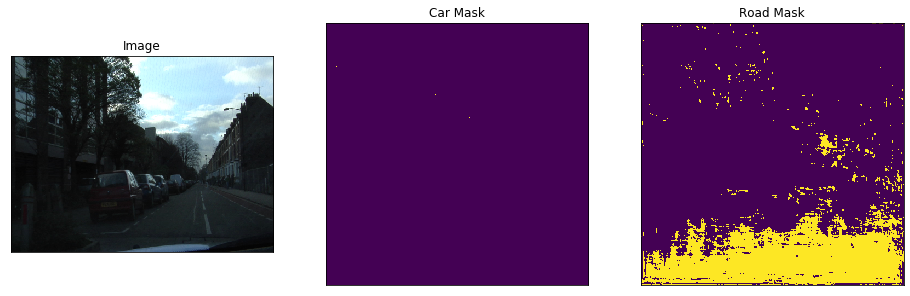

Unlabelled set before:  233
Unlabelled set after:  128
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 61.59it/s, dice_loss - 0.2534, iou_score - 0.8049]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 67.18it/s, dice_loss - 0.1831, iou_score - 0.8726]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 65.83it/s, dice_loss - 0.1793, iou_score - 0.8614]

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 67.19it/s, dice_loss - 0.1804, iou_score - 0.8633]

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 66.95it/s, dice_loss - 0.1551, iou_score - 0.8768]
Model saved!
Labelled set before:  80
Labelled set after:  140
Visualizing most uncertain results so far:


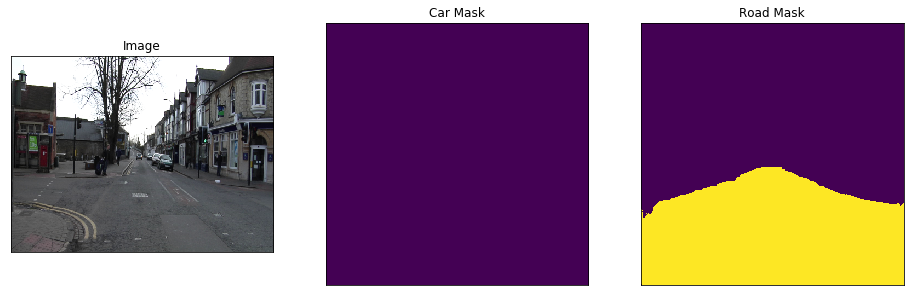

Unlabelled set before:  128
Unlabelled set after:  41
----------------------------------------


Samples selection function:
<function entropy_selection at 0x7ffa4029cae8>
------------------------------------

 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 62.79it/s, dice_loss - 0.6314, iou_score - 0.1097]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 62.54it/s, dice_loss - 0.5649, iou_score - 0.3066]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 66.91it/s, dice_loss - 0.5127, iou_score - 0.3945]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 66.49it/s, dice_loss - 0.49, iou_score - 0.4276] 
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 67.03it/s, dice_loss - 0.4515, iou_score - 0.4944]
Model saved!


  0%|          | 0/233 [00:00<?, ?it/s]

Inference on unlabelled data...


100%|██████████| 233/233 [00:10<00:00, 21.56it/s]


Min entropy: 0.82,             Mean Entropy: 1.03,             Max entropy: 1.27
Labelled set before:  20
Labelled set after:  80
Visualizing most uncertain results so far:


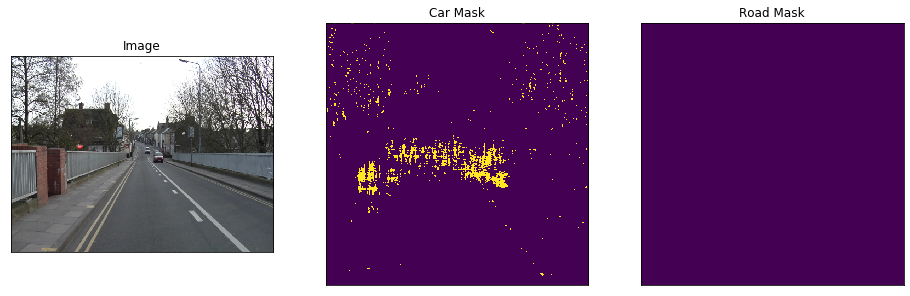

Unlabelled set before:  233
Unlabelled set after:  122
----------------------------------------


 Training a model for 5 epochs...

Epoch: 0
valid: 100%|██████████| 101/101 [00:01<00:00, 67.39it/s, dice_loss - 0.4218, iou_score - 0.5535]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:01<00:00, 67.44it/s, dice_loss - 0.3523, iou_score - 0.5935]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:01<00:00, 66.92it/s, dice_loss - 0.2896, iou_score - 0.6405]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:01<00:00, 67.19it/s, dice_loss - 0.2706, iou_score - 0.6633]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:01<00:00, 66.88it/s, dice_loss - 0.2605, iou_score - 0.7811]
Model saved!
Inference on unlabelled data...


100%|██████████| 122/122 [00:05<00:00, 21.68it/s]


Min entropy: 0.64,             Mean Entropy: 0.80,             Max entropy: 0.94
Labelled set before:  80
Labelled set after:  140
Visualizing most uncertain results so far:


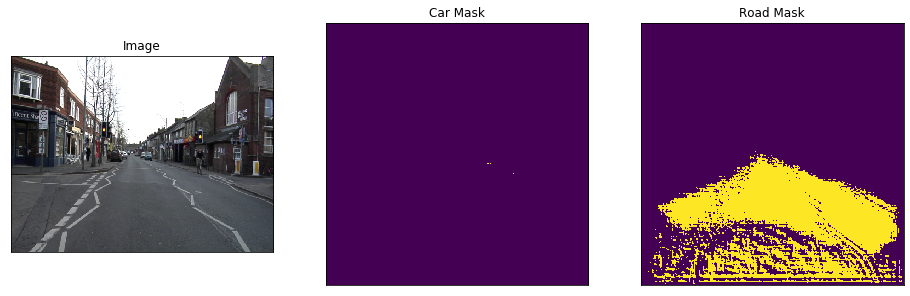

Unlabelled set before:  122
Unlabelled set after:  33
----------------------------------------



In [5]:
MAX_QUEERY_IMAGES = 120 # maximum number of images to train on during AL loop
MODEL_TRAIN_EPOCHS = 5  # number of epochs to train a model during one AL cicle
INITIAL_TRAIN_BATCH_SIZE = 20 # k: initial number of accessible labelled images
NUM_UNCERTAIN_IMAGES = [10, 20, 40, 60] # number of uncertain images to label at each AL cicle


for k in NUM_UNCERTAIN_IMAGES:
    print('------------------------------------')
    print(f'\nNumber of samples to label: {k}\n')
    print('------------------------------------')
    
    for samples_selection_fn in [random_samples_selection, entropy_selection]:
        print('\nSamples selection function:')
        print(samples_selection_fn)
        print('------------------------------------')
        # select k random samples from initial dataset and treat it as initially labelled data
        X = np.copy(X_train_paths)
        y = np.copy(y_train_paths)
        selection = np.random.choice(len(X), INITIAL_TRAIN_BATCH_SIZE, replace=False) # k
        X_train_paths_part = X[selection]
        y_train_paths_part = y[selection]

        X_test = np.copy(X_test_paths)
        y_test = np.copy(y_test_paths)

        # choose model
        unet = Unet()
        unet.epochs = MODEL_TRAIN_EPOCHS

        # main loop
        while len(X_train_paths_part) < MAX_QUEERY_IMAGES:
            # train model
            # print('Valid set size: ', len(X_valid_paths))
            print(f'\n Training a model for {MODEL_TRAIN_EPOCHS} epochs...')
            unet.train(X_train_paths_part, y_train_paths_part, X_valid_paths, y_valid_paths, verbose=True)

            selected_images_indexes = samples_selection_fn(X_test, k, unet)

            # Add labels for uncertain images to train data
            print('Labelled set before: ', len(X_train_paths_part))
            X_train_paths_part = np.concatenate([X_train_paths_part, X_test_paths[selected_images_indexes]])
            y_train_paths_part = np.concatenate([y_train_paths_part, y_test_paths[selected_images_indexes]])
            print('Labelled set after: ', len(X_train_paths_part))

            # Visualization
            print('Visualizing most uncertain results so far:')
            for i in selected_images_indexes[:1]:
                img_path = X_test[i]
                image = cv2.imread(img_path)[...,(2,1,0)]
                gt_mask = cv2.imread(y_test_paths[i])
                pr_mask = unet.predict([img_path])
                mask_np = pr_mask.squeeze().cpu().numpy().round()

                visualize(image=image, car_mask=mask_np[0,...], road_mask=mask_np[1,...])

            # Remove labelled data from validation set
            print('Unlabelled set before: ', len(X_test))
            X_test = np.delete(X_test, selected_images_indexes)
            X_test = np.delete(X_test, selected_images_indexes)
            print('Unlabelled set after: ', len(X_test))

            print('----------------------------------------\n')